In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

from custom_models.cnns import simple_cnn_bn
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
from evaluation.metrics import categorical_accuracy, sensitivity_per_class, specificity_per_class

2025-02-18 14:30:07.689638: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-18 14:30:07.689699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-18 14:30:07.689727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 14:30:07.696287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_pivot_table(df, df_name='IPO+TOGAS'):
    pivot_table = pd.crosstab(df['landmark'], df['eggim_square'])
    # Plot the pivot table (crosstab) as a stacked bar plot
    pivot_table.plot(kind='bar', stacked=True)

    # Add labels and title
    plt.title(f'[{df_name}] Tally EGGIM scores by Landmark')
    plt.ylabel('Count')
    plt.xlabel('Landmark')

    # Show the plot
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_ordinal_distribution_side_by_side_with_colors(list_of_folds, df_name='IPO+TOGAS'):
    # Determine the number of folds and datasets per fold (assumed to be 3: train, val, test)
    num_folds = len(list_of_folds)

    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(nrows=num_folds, ncols=3, figsize=(18, 5 * num_folds))

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Titles for the columns
    titles = ['Train', 'Validation', 'Test']

    # Define a color map for the ordinal values (customize as needed)
    ordinal_colors = {0: 'skyblue', 1: 'lightgreen', 2: 'lightcoral', 3: 'orange', 4: 'purple'}

    # Loop through each fold
    for fold_idx, datasets in enumerate(list_of_folds):
        # datasets is a list containing [train, val, test] DataFrames for the current fold
        for dataset_idx, dataset in enumerate(datasets):
            # Get the current axis for plotting
            ax = axes[fold_idx * 3 + dataset_idx]

            # Get the value counts for the ordinal column
            counts = dataset['eggim_square'].value_counts().sort_index()

            # Get the colors for each bar based on the ordinal value
            bar_colors = [ordinal_colors[val] for val in counts.index]

            # Plot the distribution of the 'eggim_square' (ordinal variable) with custom colors
            counts.plot(kind='bar', ax=ax, color=bar_colors)

            # Set the title for the subplot
            ax.set_title(f'Fold {fold_idx + 1}: {titles[dataset_idx]}', fontsize=14)
            ax.set_ylabel('Count')
            ax.set_xlabel('EGGIM Score (Ordinal)')

    # Add a common title
    fig.suptitle(f'[{df_name}] Distribution of EGGIM Scores for Patient Wise CV', fontsize=16)

    # Adjust layout so titles and labels don't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust to fit the suptitle

    # Show the plot
    plt.show()

# Example usage:
# Suppose list_of_folds is a list of 5 elements, where each element is a list of 3 DataFrames: [train, val, test]
# list_of_folds = [[[train1], [val1], [test1]], [[train2], [val2], [test2]], ...]

# plot_ordinal_distribution_side_by_side_with_colors(list_of_folds)


In [4]:
def plot_pivot_table_side_by_side(list_of_folds, df_name='IPO+TOGAS'):
    # Determine the number of folds and datasets per fold (assumed to be 3: train, val, test)
    num_folds = len(list_of_folds)

    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(nrows=num_folds, ncols=3, figsize=(18, 5 * num_folds))

    # Flatten axes for easier indexing (in case of 1 row, axes won't be a 2D array)
    axes = axes.flatten()

    # Titles for the columns
    titles = ['Train', 'Validation', 'Test']

    # Loop through each fold
    for fold_idx, datasets in enumerate(list_of_folds):
        # datasets is a list containing [train, val, test] DataFrames for the current fold
        for dataset_idx, dataset in enumerate(datasets):
            # Get the current axis for plotting
            ax = axes[fold_idx * 3 + dataset_idx]

            # Create the pivot table
            pivot_table = pd.crosstab(dataset['landmark'], dataset['eggim_square'])

            # Plot the pivot table as a stacked bar plot
            pivot_table.plot(kind='bar', stacked=True, ax=ax, legend=True)

            # Set the title for the subplot
            ax.set_title(f'Fold {fold_idx + 1}: {titles[dataset_idx]}', fontsize=14)
            ax.set_ylabel('Count')
            ax.set_xlabel('Landmark')

    # Add a common title
    fig.suptitle(f'[{df_name}] Tally EGGIM scores by Landmark for Patient-wise C.V.', fontsize=16)

    # Adjust layout    so titles and labels don't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust to fit the suptitle

    # Show the plot
    plt.show()


In [5]:
target_dir = '../test_files/EGGIMazing/Dataset3'
model_weights_directory = '../logs/crossvalidation/temp_splits/'

In [6]:
num_folds = 65
dp = DatasetProcessor(target_dir)
df = dp.process()
def replace_landmark_name(landmark):
    new_landmark_name = {'ii': 'distal body',
                    'ix': 'distal lc',
                    'vi': 'proximal ant lc',
                    'vii': 'proximal ant gc/pw',
                    'viii': 'incisura r',
                    'x': 'upper body r',
                    'xii': 'upper body ant'}
    landmark_number = landmark.split('.')[0]
    return new_landmark_name[landmark_number]

# Define the mapping
mapping = {
    'distal lc': 'Body LC',
    'upper body r': 'Body LC',
    'distal body': 'Body GC',
    'upper body ant': 'Body GC',
    'incisura r': 'Incisura',
    'proximal ant gc/pw': 'Antrum GC',
    'proximal ant lc': 'Antrum LC'
}

df['landmark'] = df['landmark'].apply(replace_landmark_name)
df['landmark'] = df['landmark'].replace(mapping)
togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)

In [7]:
ipo_landmark_table = df.pivot_table(index='landmark', values='eggim_square', aggfunc=['count'])


<Figure size 1000x600 with 0 Axes>

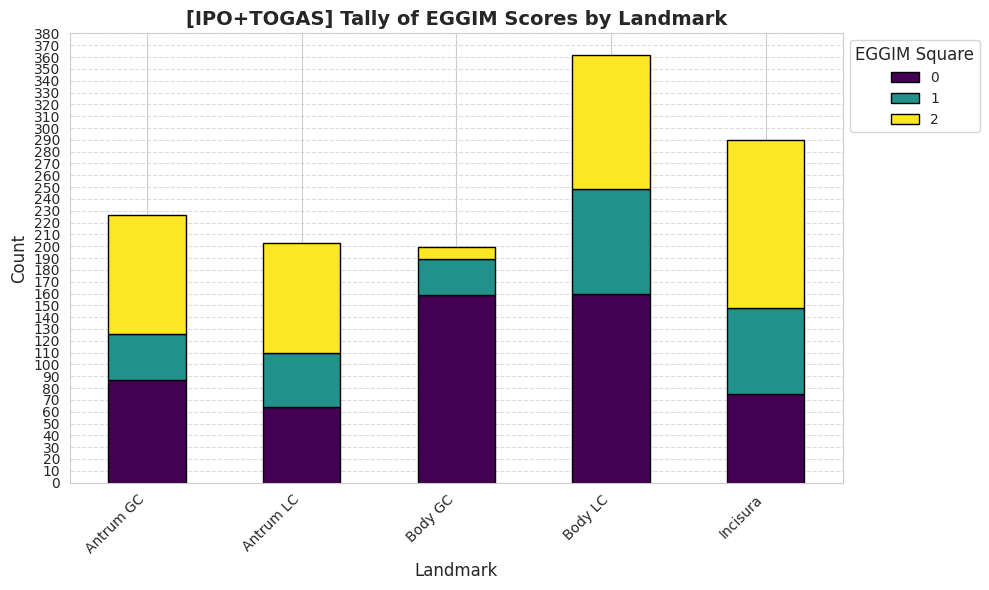

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_pivot_table(df, df_name='IPO+TOGAS'):
    # Create a pivot table (crosstab)

    pivot_table = pd.crosstab(df['landmark'], df['eggim_global'])

    # Set figure size
    plt.figure(figsize=(10, 6))

    # Plot the pivot table as a stacked bar plot
    ax = pivot_table.plot(
        kind='bar',
        stacked=True,
        colormap='viridis',  # Use a scientific colormap
        figsize=(10, 6),
        edgecolor='black'  # Add edges for bar clarity
    )

    # Add labels and title with consistent font sizes
    plt.title(f'[{df_name}] Tally of EGGIM Scores by Landmark', fontsize=14, fontweight='bold')
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Landmark', fontsize=12)

    # Rotate x-axis labels for clarity
    plt.xticks(rotation=45, fontsize=10, ha='right')

    # Adjust y-axis ticks and add grid for clarity
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))  # Adjust tick intervals
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add a legend with a title
    plt.legend(
        title='EGGIM Square',
        title_fontsize=12,
        fontsize=10,
        loc='upper left',
        bbox_to_anchor=(1.0, 1.0)  # Move legend outside plot
    )

    # Tight layout to prevent clipping
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
# Assuming df is your DataFrame
plot_pivot_table(df)


/tmp/ipykernel_2665930/581597999.py:47: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[val], edgecolor='black') for val in unique_values]


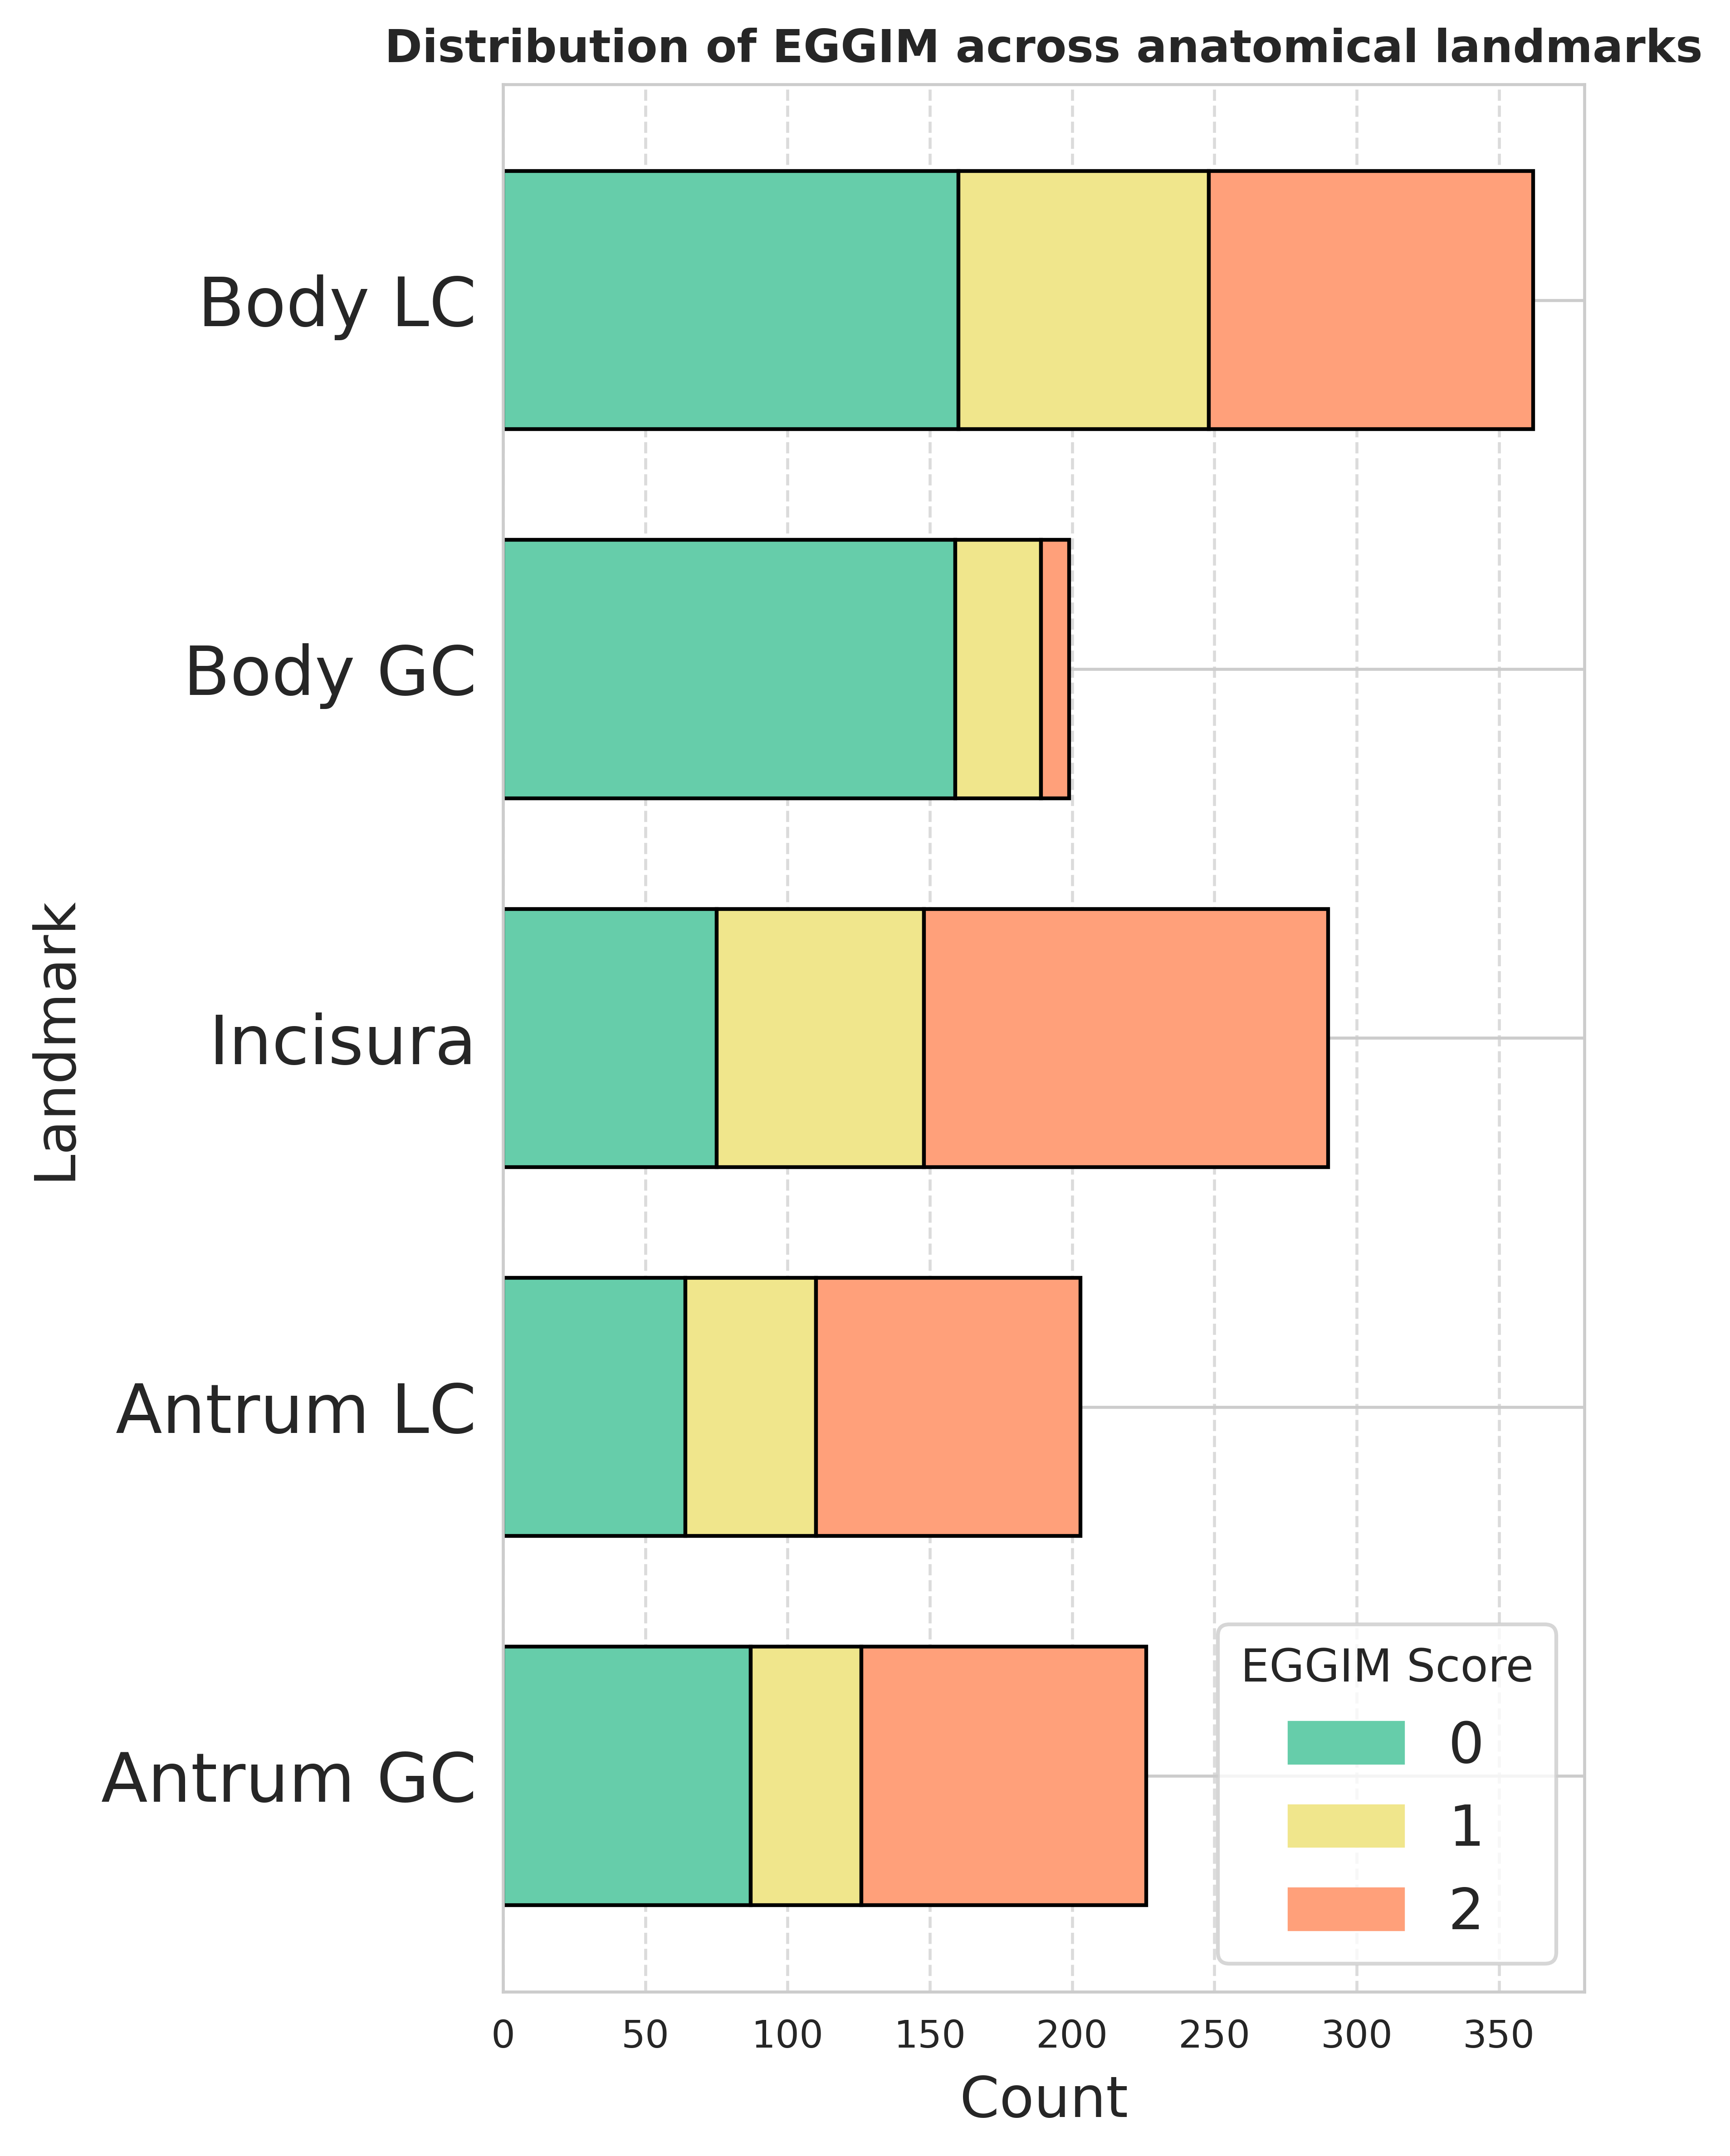

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_pivot_table(df, df_name='Distribution of EGGIM across anatomical landmarks', dpi=600):
    # Set the custom order for the 'landmark' column in each dataframe
    custom_order = ['Antrum GC', 'Antrum LC',  'Incisura', 'Body GC', 'Body LC']
    df_ = df.copy()
    df_['landmark'] = pd.Categorical(df_['landmark'], categories=custom_order, ordered=True)

    # Create a pivot table (crosstab)
    pivot_table = pd.crosstab(df_['landmark'], df_['eggim_global'])



    # Find all unique EGGIM score values
    unique_values = sorted(df['eggim_global'].unique())

    # Define colors for each EGGIM score category
    colors = ['mediumaquamarine', 'khaki', 'lightsalmon']  # Adjust or add more colors if needed
    color_mapping = {value: colors[i % len(colors)] for i, value in enumerate(unique_values)}

    fig, ax = plt.subplots(figsize=(6, 8), dpi=dpi)  # Adjusted figure size

    # Number of landmarks
    y = np.arange(len(pivot_table.index))
    width = 0.7  # width of bars

    # Plot the stacked bars
    left = np.zeros(len(y))
    for eggim in unique_values:
        x = pivot_table[eggim].values
        ax.barh(y, x, width, left=left,
                color=color_mapping[eggim], edgecolor='black', label=f'EGGIM {eggim}')
        left += x

    # Set axis labels and title
    ax.set_ylabel('Landmark', fontsize=15, labelpad=5)
    ax.set_xlabel('Count', fontsize=15, labelpad=5)
    ax.set_yticks(y)
    ax.set_yticklabels(pivot_table.index, fontsize=8)
    ax.tick_params(axis='y', labelsize=18)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.set_title(f'{df_name}', fontsize=12, fontweight='bold')

    # Add a horizontal legend below the title
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[val], edgecolor='black') for val in unique_values]
    labels = [str(val) for val in unique_values]
    ax.legend(handles, labels, title='EGGIM Score', title_fontsize=12, fontsize=15, ncol=1, loc='best')

    plt.tight_layout(pad=1)
    plt.show()

plot_pivot_table(df)

In [13]:
def stats_(df, df_name='Distribution of EGGIM across anatomical landmarks', dpi=600):
    # Set the custom order for the 'landmark' column in each dataframe
    custom_order = ['Antrum GC', 'Antrum LC',  'Incisura', 'Body GC', 'Body LC']
    df_ = df.copy()
    df_['landmark'] = pd.Categorical(df_['landmark'], categories=custom_order, ordered=True)

    # Create a pivot table (crosstab)
    pivot_table = pd.crosstab(df_['landmark'], df_['eggim_global'])



    # Find all unique EGGIM score values
    unique_values = sorted(df['eggim_global'].unique())
    print(pivot_table)

stats_(df)

import pandas as pd

def stats_percentage(df, df_name='Distribution of EGGIM across anatomical landmarks', dpi=600):
    # Set the custom order for the 'landmark' column in each dataframe
    custom_order = ['Antrum GC', 'Antrum LC', 'Incisura', 'Body GC', 'Body LC']
    df_ = df.copy()
    df_['landmark'] = pd.Categorical(df_['landmark'], categories=custom_order, ordered=True)

    # Create a pivot table (crosstab)
    pivot_table = pd.crosstab(df_['landmark'], df_['eggim_global'])

    # Convert values to row-wise percentages
    pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

    # Display the percentage table
    print(pivot_table_percentage)

    return pivot_table_percentage

# Example usage
stats_percentage(df)


eggim_global    0   1    2
landmark                  
Antrum GC      87  39  100
Antrum LC      64  46   93
Incisura       75  73  142
Body GC       159  30   10
Body LC       160  88  114
eggim_global          0          1          2
landmark                                     
Antrum GC     38.495575  17.256637  44.247788
Antrum LC     31.527094  22.660099  45.812808
Incisura      25.862069  25.172414  48.965517
Body GC       79.899497  15.075377   5.025126
Body LC       44.198895  24.309392  31.491713


eggim_global,0,1,2
landmark,,,
Antrum GC,38.495575,17.256637,44.247788
Antrum LC,31.527094,22.660099,45.812808
Incisura,25.862069,25.172414,48.965517
Body GC,79.899497,15.075377,5.025126
Body LC,44.198895,24.309392,31.491713


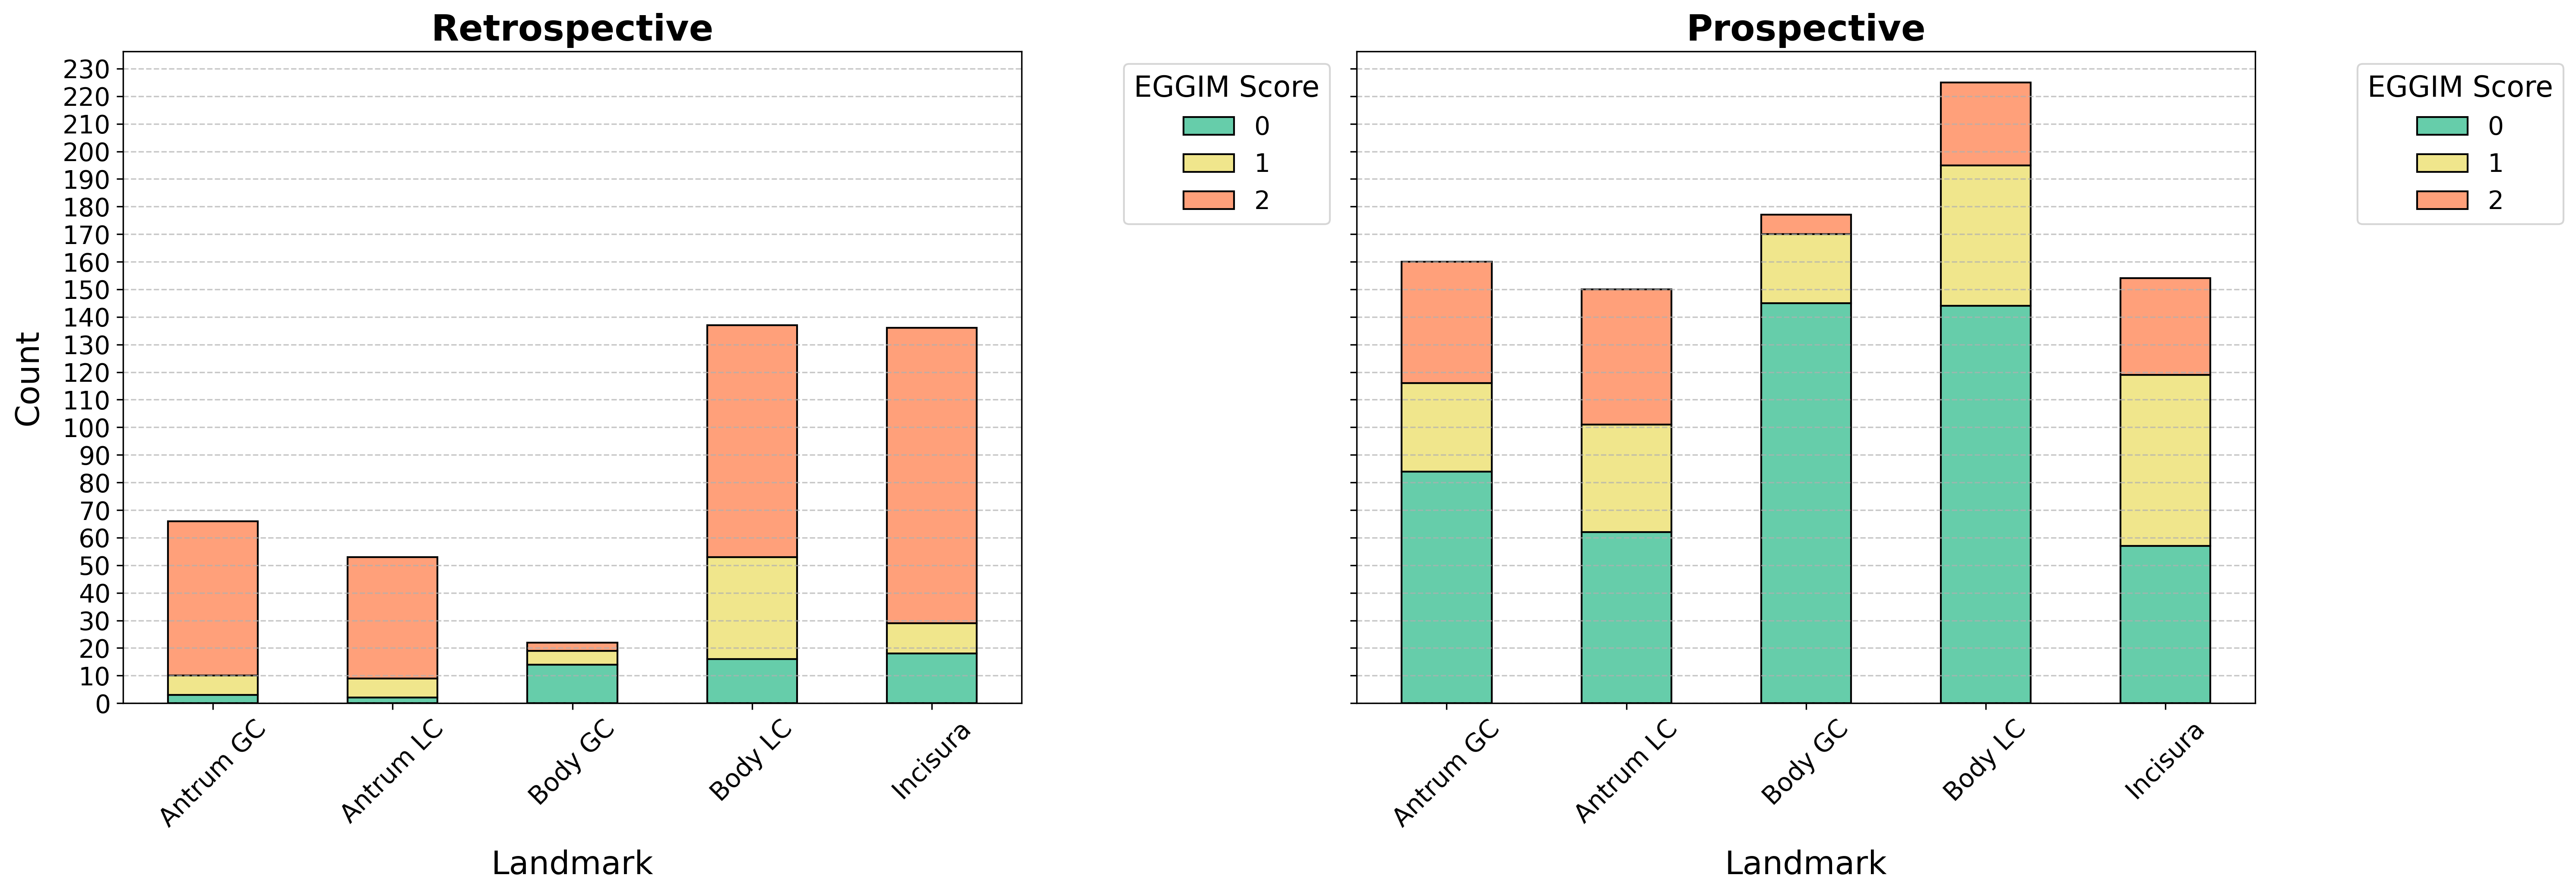

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_pivot_table_side_by_side(df1, df2, df1_name='IPO+TOGAS 1', df2_name='IPO+TOGAS 2', dpi=300):
    # Create pivot tables (crosstabs)
    pivot_table1 = pd.crosstab(df1['landmark'], df1['eggim_global'])
    pivot_table2 = pd.crosstab(df2['landmark'], df2['eggim_global'])

    # Define consistent colors for each unique value in 'eggim_global'
    unique_values = sorted(set(df1['eggim_global']).union(set(df2['eggim_global'])))
    colors = ['mediumaquamarine', 'khaki', 'lightsalmon']  # Example colors
    color_mapping = {value: colors[i % len(colors)] for i, value in enumerate(unique_values)}

    # Assign colors based on the mapping
    bar_colors = [color_mapping[value] for value in pivot_table1.columns]

    # Set up the figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)  # Larger size for better readability
    fig.dpi = dpi  # Set DPI for higher resolution

    # Plot the first DataFrame
    ax1 = pivot_table1.plot(
        kind='bar',
        stacked=True,
        color=bar_colors,  # Apply consistent colors
        ax=axes[0],
        edgecolor='black'  # Add edges for bar clarity
    )
    ax1.set_title(f'{df1_name}', fontsize=20, fontweight='bold')
    ax1.set_ylabel('Count', fontsize=18, labelpad=10)
    ax1.set_xlabel('Landmark', fontsize=18, labelpad=10)
    ax1.tick_params(axis='x', rotation=45, labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(10))  # Adjust tick intervals

    # Plot the second DataFrame
    ax2 = pivot_table2.plot(
        kind='bar',
        stacked=True,
        color=bar_colors,  # Apply consistent colors
        ax=axes[1],
        edgecolor='black'  # Add edges for bar clarity
    )
    ax2.set_title(f'{df2_name}', fontsize=20, fontweight='bold')
    ax2.set_xlabel('Landmark', fontsize=18, labelpad=10)
    ax2.tick_params(axis='x', rotation=45, labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # Add legends to both plots
    ax1.legend(
        title='EGGIM Score',
        title_fontsize=16,
        fontsize=14,
        loc='upper left',
        bbox_to_anchor=(1.1, 1.0)  # Move legend outside plot
    )
    ax2.legend(
        title='EGGIM Score',
        title_fontsize=16,
        fontsize=14,
        loc='upper left',
        bbox_to_anchor=(1.1, 1.0)  # Move legend outside plot
    )

    # Add tight layout to adjust spacing and avoid overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
plot_pivot_table_side_by_side(df_ipo, df_togas, 'Retrospective', 'Prospective', dpi=300)


/tmp/ipykernel_2555206/839593533.py:60: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1,color=color_mapping[val], edgecolor='black') for val in unique_values]


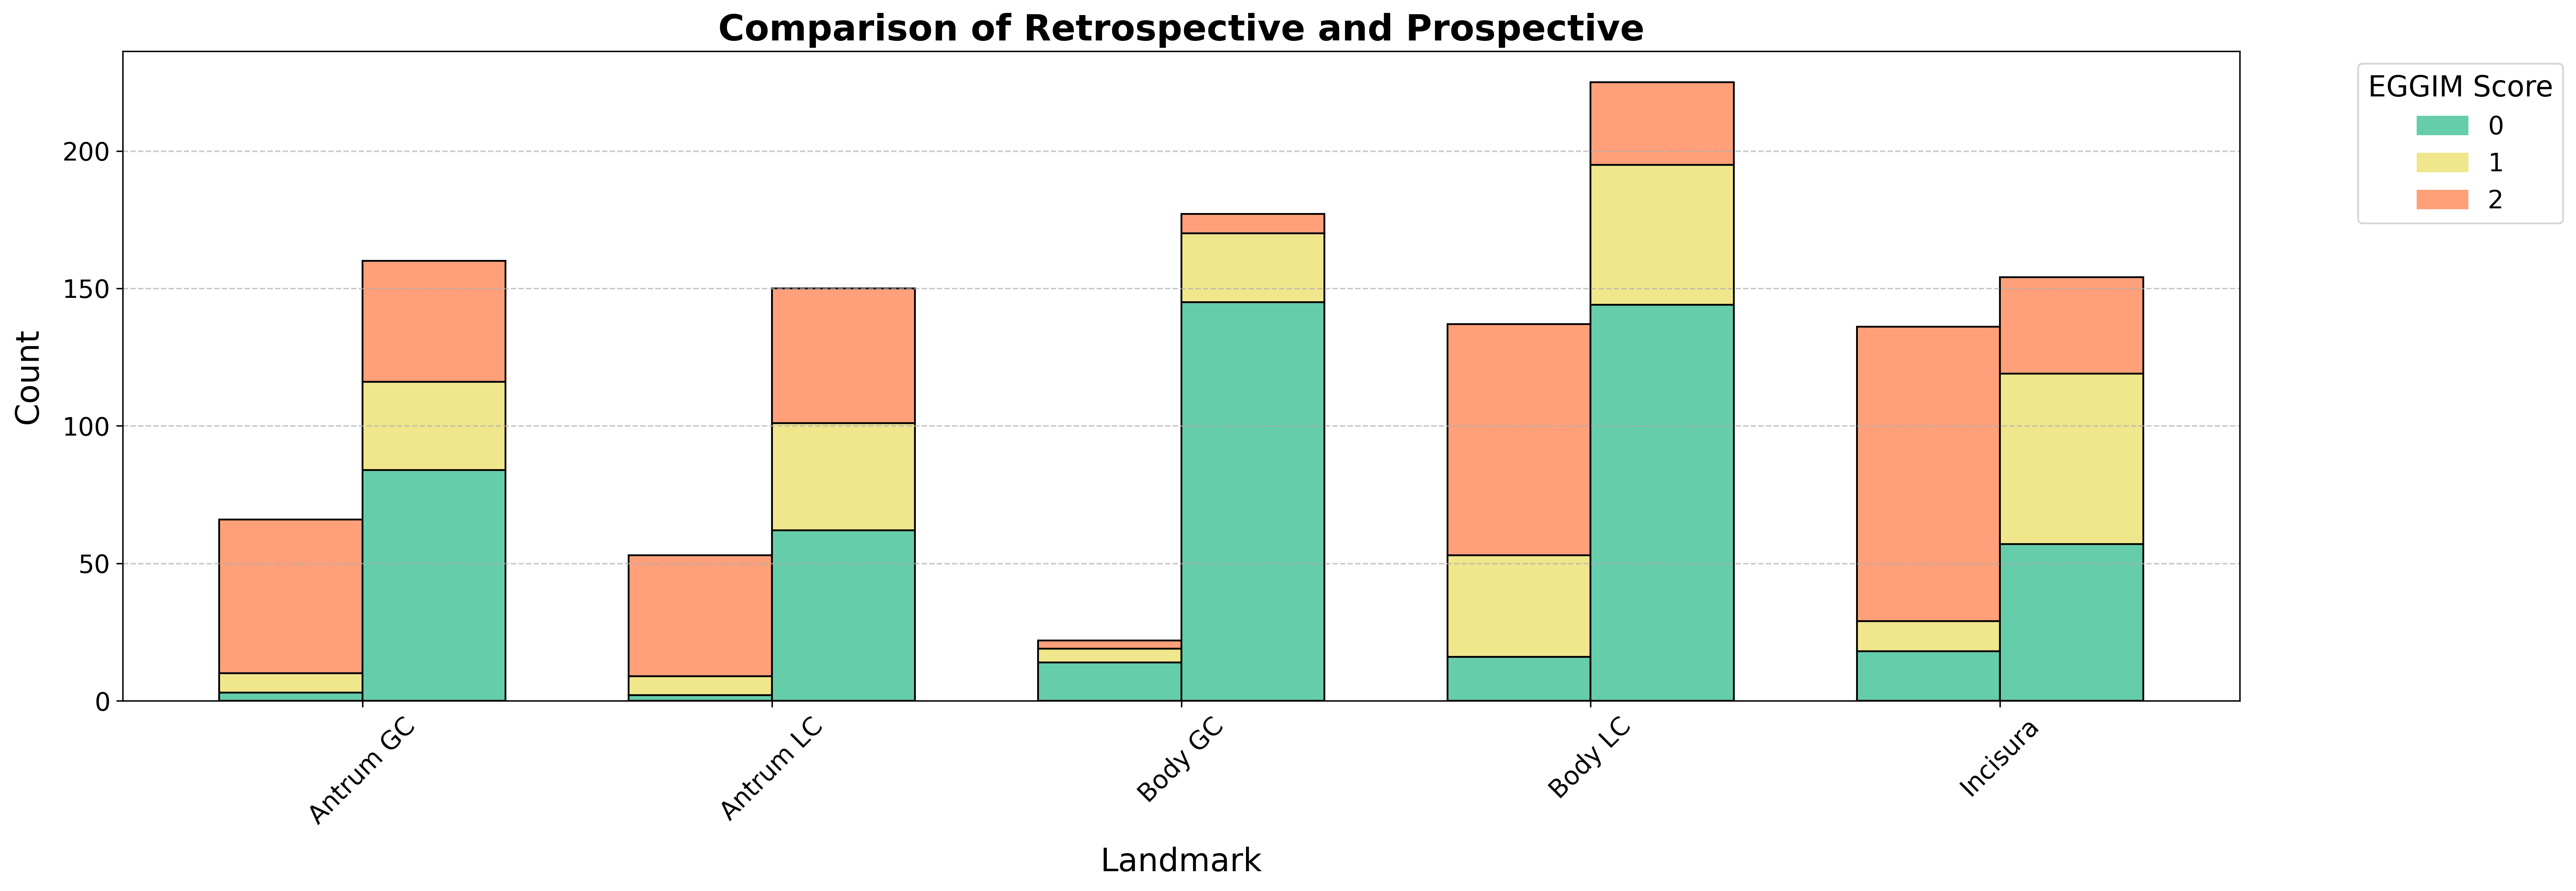

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def plot_pivot_table_grouped_stacked(df1, df2, df1_name='IPO+TOGAS 1', df2_name='IPO+TOGAS 2', dpi=300):
    # Create pivot tables
    pivot_table1 = pd.crosstab(df1['landmark'], df1['eggim_global'])
    pivot_table2 = pd.crosstab(df2['landmark'], df2['eggim_global'])

    # Find all unique EGGIM score values across both dataframes
    unique_values = sorted(set(df1['eggim_global']).union(set(df2['eggim_global'])))

    # Define colors for each EGGIM score category
    colors = ['mediumaquamarine', 'khaki', 'lightsalmon']  # Adjust or add more colors if needed
    color_mapping = {value: colors[i % len(colors)] for i, value in enumerate(unique_values)}

    # Convert the pivot tables to have a multi-index on columns: (DatasetName, EGGIM_Score)
    pivot_table1.columns = pd.MultiIndex.from_product([[df1_name], pivot_table1.columns])
    pivot_table2.columns = pd.MultiIndex.from_product([[df2_name], pivot_table2.columns])

    # Combine both pivot tables horizontally
    combined = pd.concat([pivot_table1, pivot_table2], axis=1)

    # Ensure the columns are in a consistent order: first by dataset, then by EGGIM score
    combined = combined.reindex(columns=pd.MultiIndex.from_product([[df1_name, df2_name], unique_values]))

    fig, ax = plt.subplots(figsize=(20, 7), dpi=dpi)

    # Number of landmarks
    x = np.arange(len(combined.index))
    width = 0.35  # width of each group's bars

    # Plot the first dataset's stacked bars (df1)
    bottom = np.zeros(len(x))
    for eggim in unique_values:
        y = combined[(df1_name, eggim)].values
        ax.bar(x - width/2, y, width, bottom=bottom,
               color=color_mapping[eggim], edgecolor='black')
        bottom += y

    # Plot the second dataset's stacked bars (df2)
    bottom = np.zeros(len(x))
    for eggim in unique_values:
        y = combined[(df2_name, eggim)].values
        ax.bar(x + width/2, y, width, bottom=bottom,
               color=color_mapping[eggim], edgecolor='black')
        bottom += y

    # Set axis labels and title
    ax.set_xlabel('Landmark', fontsize=18, labelpad=10)
    ax.set_ylabel('Count', fontsize=18, labelpad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(combined.index, rotation=45, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_title(f'Comparison of {df1_name} and {df2_name}', fontsize=20, fontweight='bold')

    # Add a legend
    handles = [plt.Rectangle((0,0),1,1,color=color_mapping[val], edgecolor='black') for val in unique_values]
    labels = [str(val) for val in unique_values]
    ax.legend(handles, labels, title='EGGIM Score', title_fontsize=16, fontsize=14,
              loc='upper left', bbox_to_anchor=(1.05,1.0))

    plt.tight_layout()
    plt.show()

# Example usage:
plot_pivot_table_grouped_stacked(df_ipo, df_togas, 'Retrospective', 'Prospective', dpi=300)


/tmp/ipykernel_2555206/573001900.py:59: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[val], edgecolor='black') for val in unique_values]


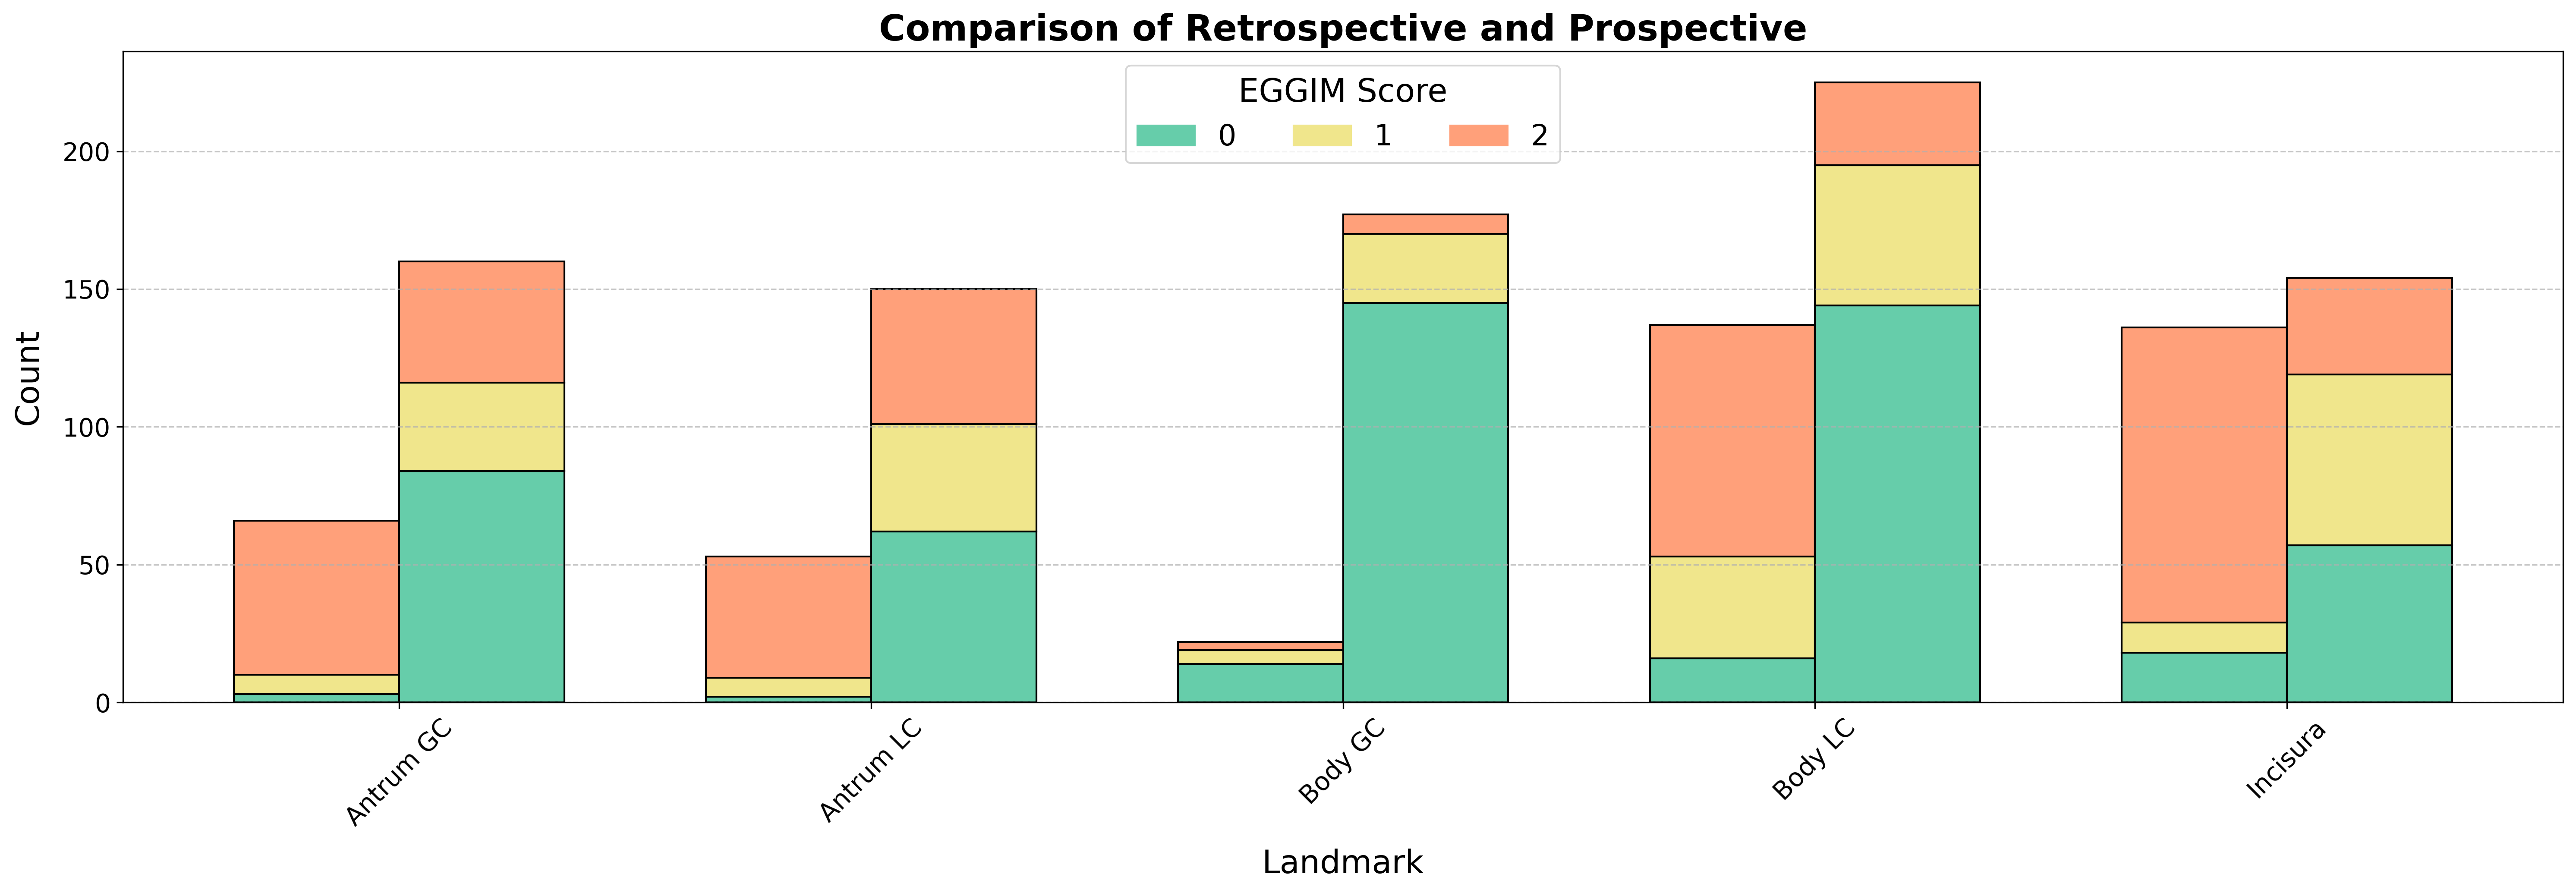

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_pivot_table_grouped_stacked(df1, df2, df1_name='IPO+TOGAS 1', df2_name='IPO+TOGAS 2', dpi=300):
    # Create pivot tables
    pivot_table1 = pd.crosstab(df1['landmark'], df1['eggim_global'])
    pivot_table2 = pd.crosstab(df2['landmark'], df2['eggim_global'])

    # Find all unique EGGIM score values across both dataframes
    unique_values = sorted(set(df1['eggim_global']).union(set(df2['eggim_global'])))

    # Define colors for each EGGIM score category
    colors = ['mediumaquamarine', 'khaki', 'lightsalmon']  # Adjust or add more colors if needed
    color_mapping = {value: colors[i % len(colors)] for i, value in enumerate(unique_values)}

    # Convert the pivot tables to have a multi-index on columns: (DatasetName, EGGIM_Score)
    pivot_table1.columns = pd.MultiIndex.from_product([[df1_name], pivot_table1.columns])
    pivot_table2.columns = pd.MultiIndex.from_product([[df2_name], pivot_table2.columns])

    # Combine both pivot tables horizontally
    combined = pd.concat([pivot_table1, pivot_table2], axis=1)

    # Ensure the columns are in a consistent order: first by dataset, then by EGGIM score
    combined = combined.reindex(columns=pd.MultiIndex.from_product([[df1_name, df2_name], unique_values]))

    fig, ax = plt.subplots(figsize=(20, 7), dpi=dpi)

    # Number of landmarks
    x = np.arange(len(combined.index))
    width = 0.35  # width of each group's bars

    # Plot the first dataset's stacked bars (df1)
    bottom = np.zeros(len(x))
    for eggim in unique_values:
        y = combined[(df1_name, eggim)].values
        ax.bar(x - width/2, y, width, bottom=bottom,
               color=color_mapping[eggim], edgecolor='black')
        bottom += y

    # Plot the second dataset's stacked bars (df2)
    bottom = np.zeros(len(x))
    for eggim in unique_values:
        y = combined[(df2_name, eggim)].values
        ax.bar(x + width/2, y, width, bottom=bottom,
               color=color_mapping[eggim], edgecolor='black')
        bottom += y

    # Set axis labels and title
    ax.set_xlabel('Landmark', fontsize=18, labelpad=10)
    ax.set_ylabel('Count', fontsize=18, labelpad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(combined.index, rotation=45, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_title(f'Comparison of {df1_name} and {df2_name}', fontsize=20, fontweight='bold')

    # Add a horizontal legend below the title
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[val], edgecolor='black') for val in unique_values]
    labels = [str(val) for val in unique_values]
    ax.legend(handles, labels, title='EGGIM Score', title_fontsize=18, fontsize=16,
              loc='upper center',  ncol=len(unique_values))

    plt.tight_layout()
    plt.show()

# Example usage:
plot_pivot_table_grouped_stacked(df_ipo, df_togas, 'Retrospective', 'Prospective', dpi=300)


In [34]:
x1 = df_togas['eggim_global'].values
x2 = df_togas['eggim_square'].values
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa
kappa_score = cohen_kappa_score(x1, x2)

print(f"Cohen's Kappa Score: {kappa_score}")
# Bootstrap resampling for confidence interval
n_bootstraps = 1000
kappa_bootstrap = []

for _ in range(n_bootstraps):
    indices = np.random.choice(len(x1), len(x1), replace=True)
    kappa_bootstrap.append(cohen_kappa_score(x1[indices], x2[indices]))

# Compute 99% confidence interval
lower_bound, upper_bound = np.percentile(kappa_bootstrap, [0.5, 99.5])

# Print results
print(f"Cohen's Kappa Score: {kappa_score:.4f}")
print(f"99% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})")

Cohen's Kappa Score: 0.9459189408605508
Cohen's Kappa Score: 0.9459
99% Confidence Interval: (0.9181, 0.9692)


/tmp/ipykernel_2555206/3779571141.py:59: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[val], edgecolor='black') for val in unique_values]


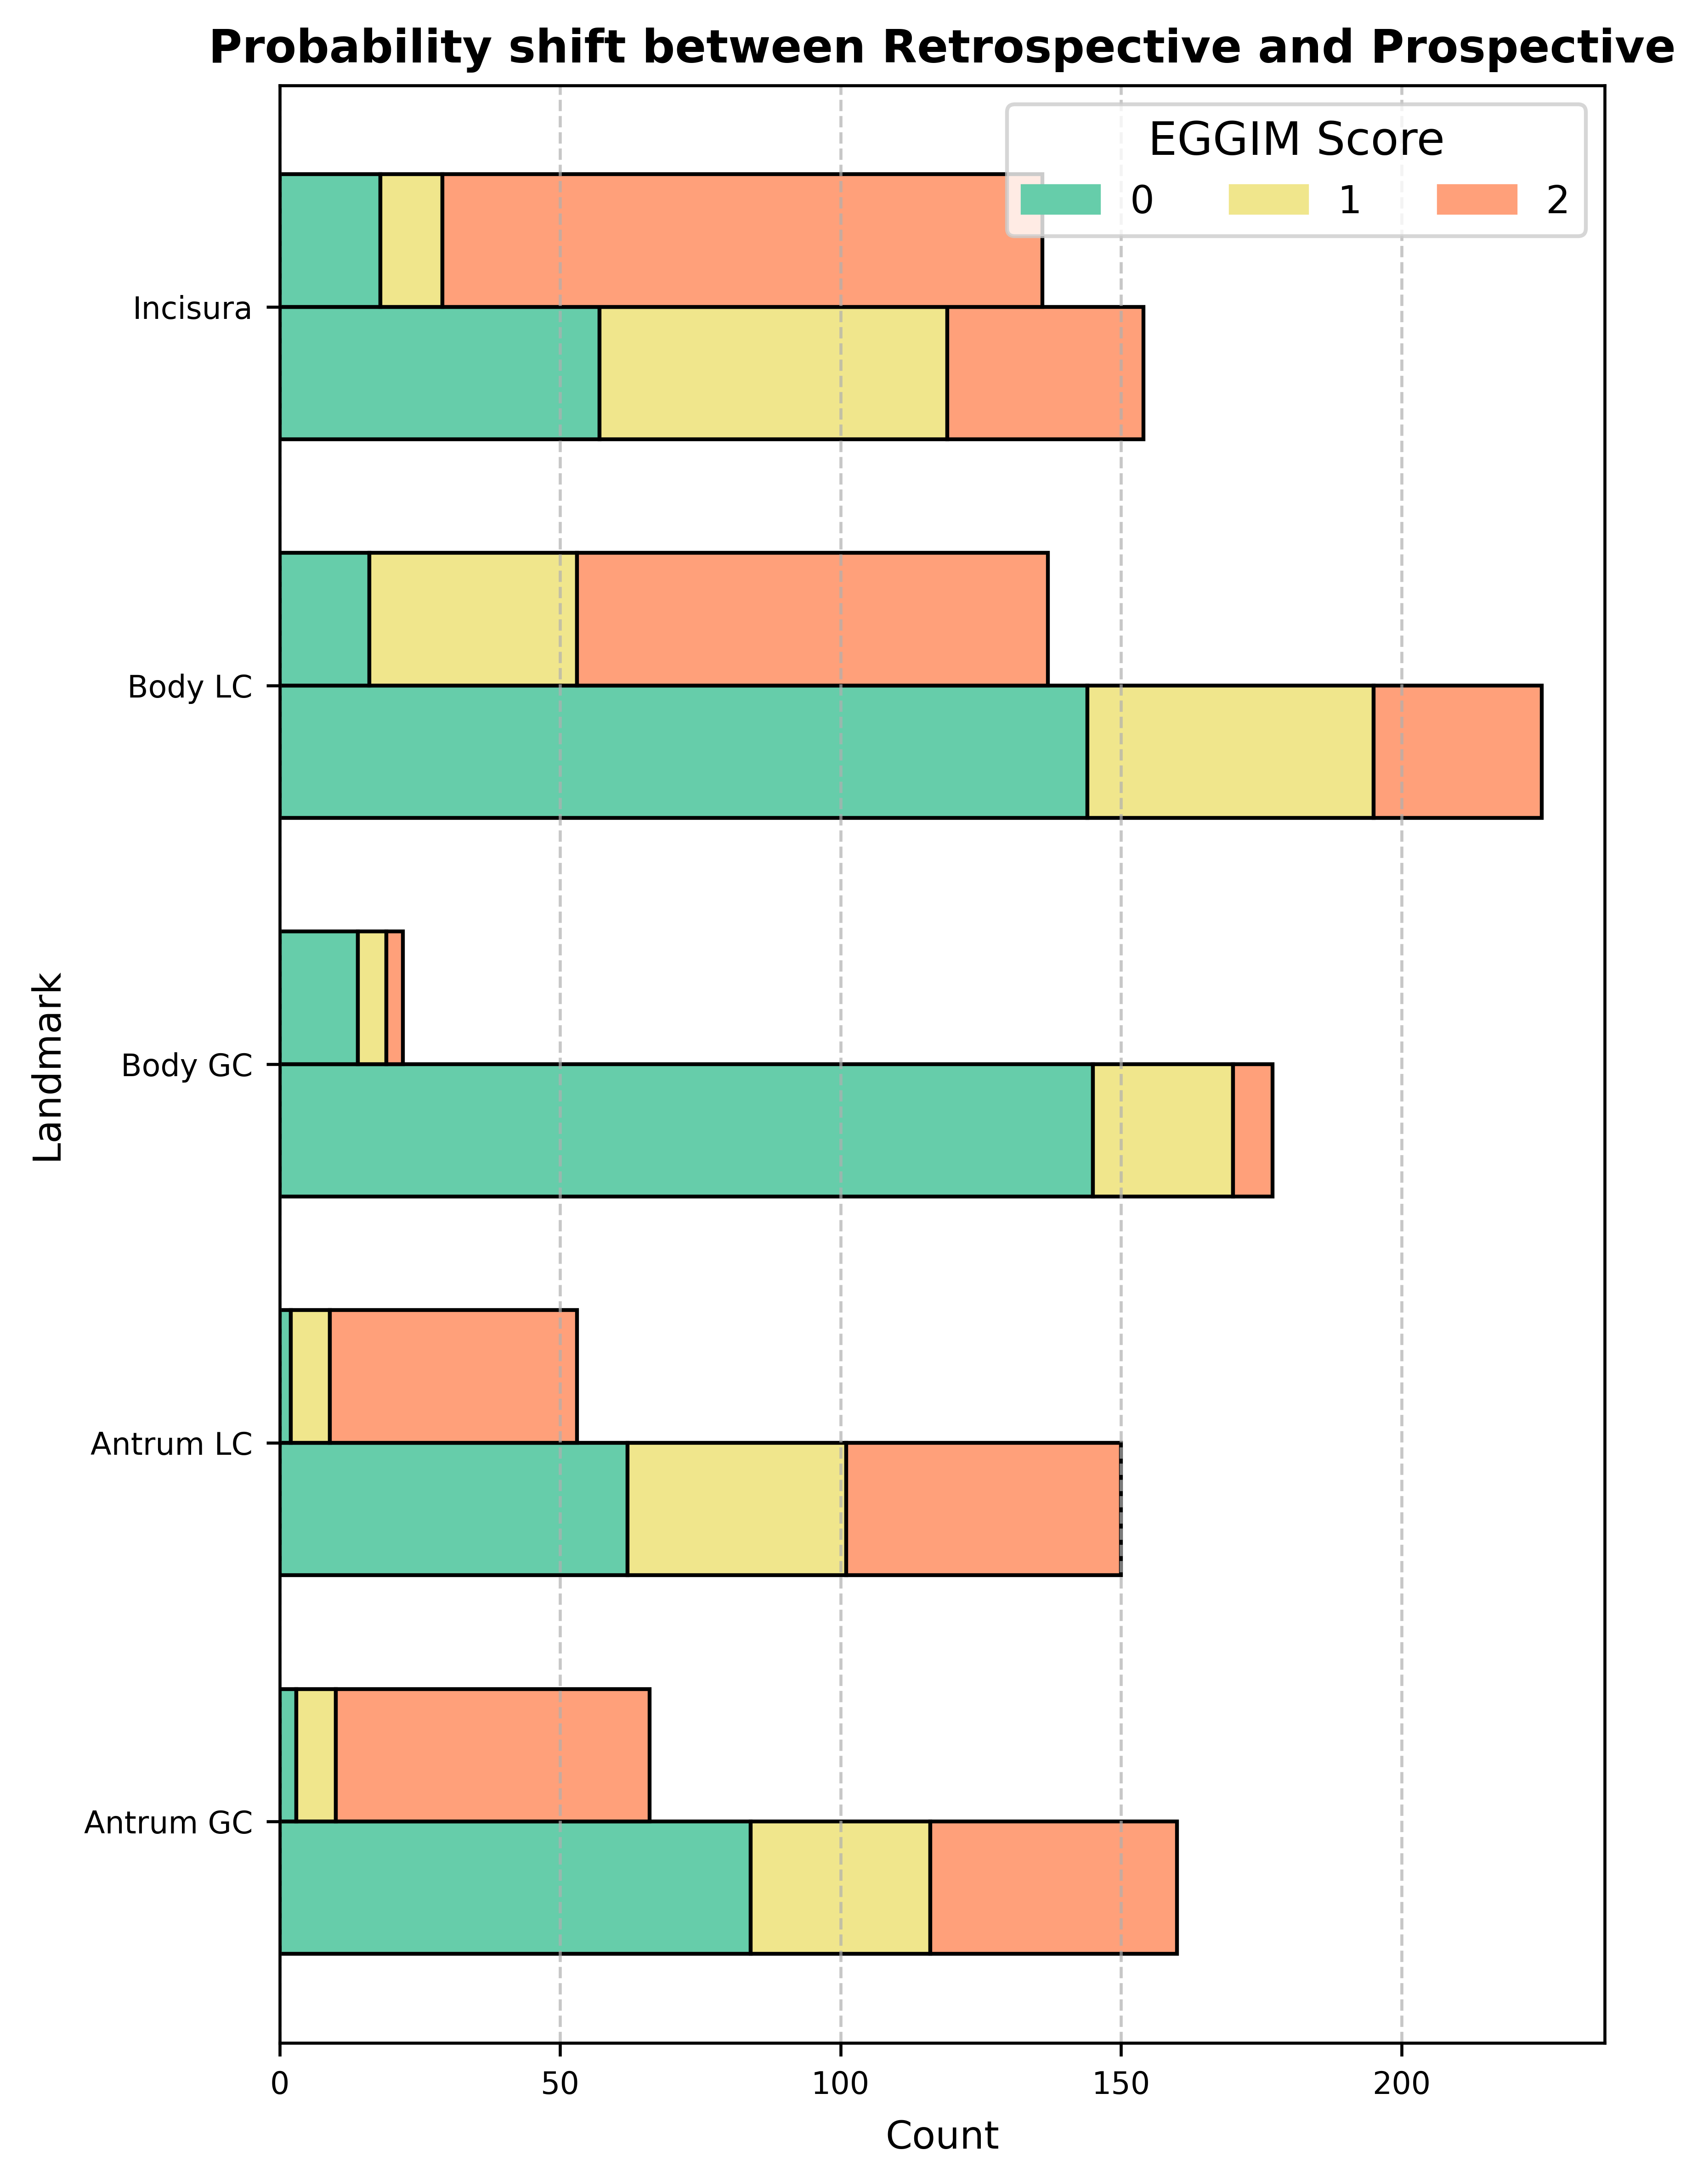

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_pivot_table_grouped_stacked(df1, df2, df1_name='IPO+TOGAS 1', df2_name='IPO+TOGAS 2', dpi=600):
    # Create pivot tables
    pivot_table1 = pd.crosstab(df1['landmark'], df1['eggim_global'])
    pivot_table2 = pd.crosstab(df2['landmark'], df2['eggim_global'])

    # Find all unique EGGIM score values across both dataframes
    unique_values = sorted(set(df1['eggim_global']).union(set(df2['eggim_global'])))

    # Define colors for each EGGIM score category
    colors = ['mediumaquamarine', 'khaki', 'lightsalmon']  # Adjust or add more colors if needed
    color_mapping = {value: colors[i % len(colors)] for i, value in enumerate(unique_values)}

    # Convert the pivot tables to have a multi-index on columns: (DatasetName, EGGIM_Score)
    pivot_table1.columns = pd.MultiIndex.from_product([[df1_name], pivot_table1.columns])
    pivot_table2.columns = pd.MultiIndex.from_product([[df2_name], pivot_table2.columns])

    # Combine both pivot tables horizontally
    combined = pd.concat([pivot_table1, pivot_table2], axis=1)

    # Ensure the columns are in a consistent order: first by dataset, then by EGGIM score
    combined = combined.reindex(columns=pd.MultiIndex.from_product([[df1_name, df2_name], unique_values]))

    fig, ax = plt.subplots(figsize=(6, 8), dpi=dpi)  # Adjust figure size for single-column fit

    # Number of landmarks
    y = np.arange(len(combined.index))
    width = 0.35  # width of each group's bars

    # Plot the first dataset's stacked bars (df1)
    left = np.zeros(len(y))
    for eggim in unique_values:
        x = combined[(df1_name, eggim)].values
        ax.barh(y - width/2, x, width, left=left,
                color=color_mapping[eggim], edgecolor='black', label=f'{df1_name} - {eggim}')
        left += x

    # Plot the second dataset's stacked bars (df2)
    left = np.zeros(len(y))
    for eggim in unique_values:
        x = combined[(df2_name, eggim)].values
        ax.barh(y + width/2, x, width, left=left,
                color=color_mapping[eggim], edgecolor='black', label=f'{df2_name} - {eggim}')
        left += x

    # Set axis labels and title
    ax.set_ylabel('Landmark', fontsize=10, labelpad=5)
    ax.set_xlabel('Count', fontsize=10, labelpad=5)
    ax.set_yticks(y)
    ax.set_yticklabels(combined.index, fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.set_title(f'Probability shift between {df1_name} and {df2_name}', fontsize=12, fontweight='bold')

    # Add a horizontal legend below the title
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[val], edgecolor='black') for val in unique_values]
    labels = [str(val) for val in unique_values]
    ax.legend(handles, labels, title='EGGIM Score', title_fontsize=12, fontsize=10, ncol=len(unique_values))

    plt.tight_layout(pad=1)
    plt.savefig('prob_shift.png', bbox_inches='tight', dpi=300)
    plt.show()

# Example usage:
plot_pivot_table_grouped_stacked(df_togas, df_ipo, 'Retrospective', 'Prospective', dpi=600)


/tmp/ipykernel_2555206/2214225396.py:69: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[val], edgecolor='black') for val in unique_values]


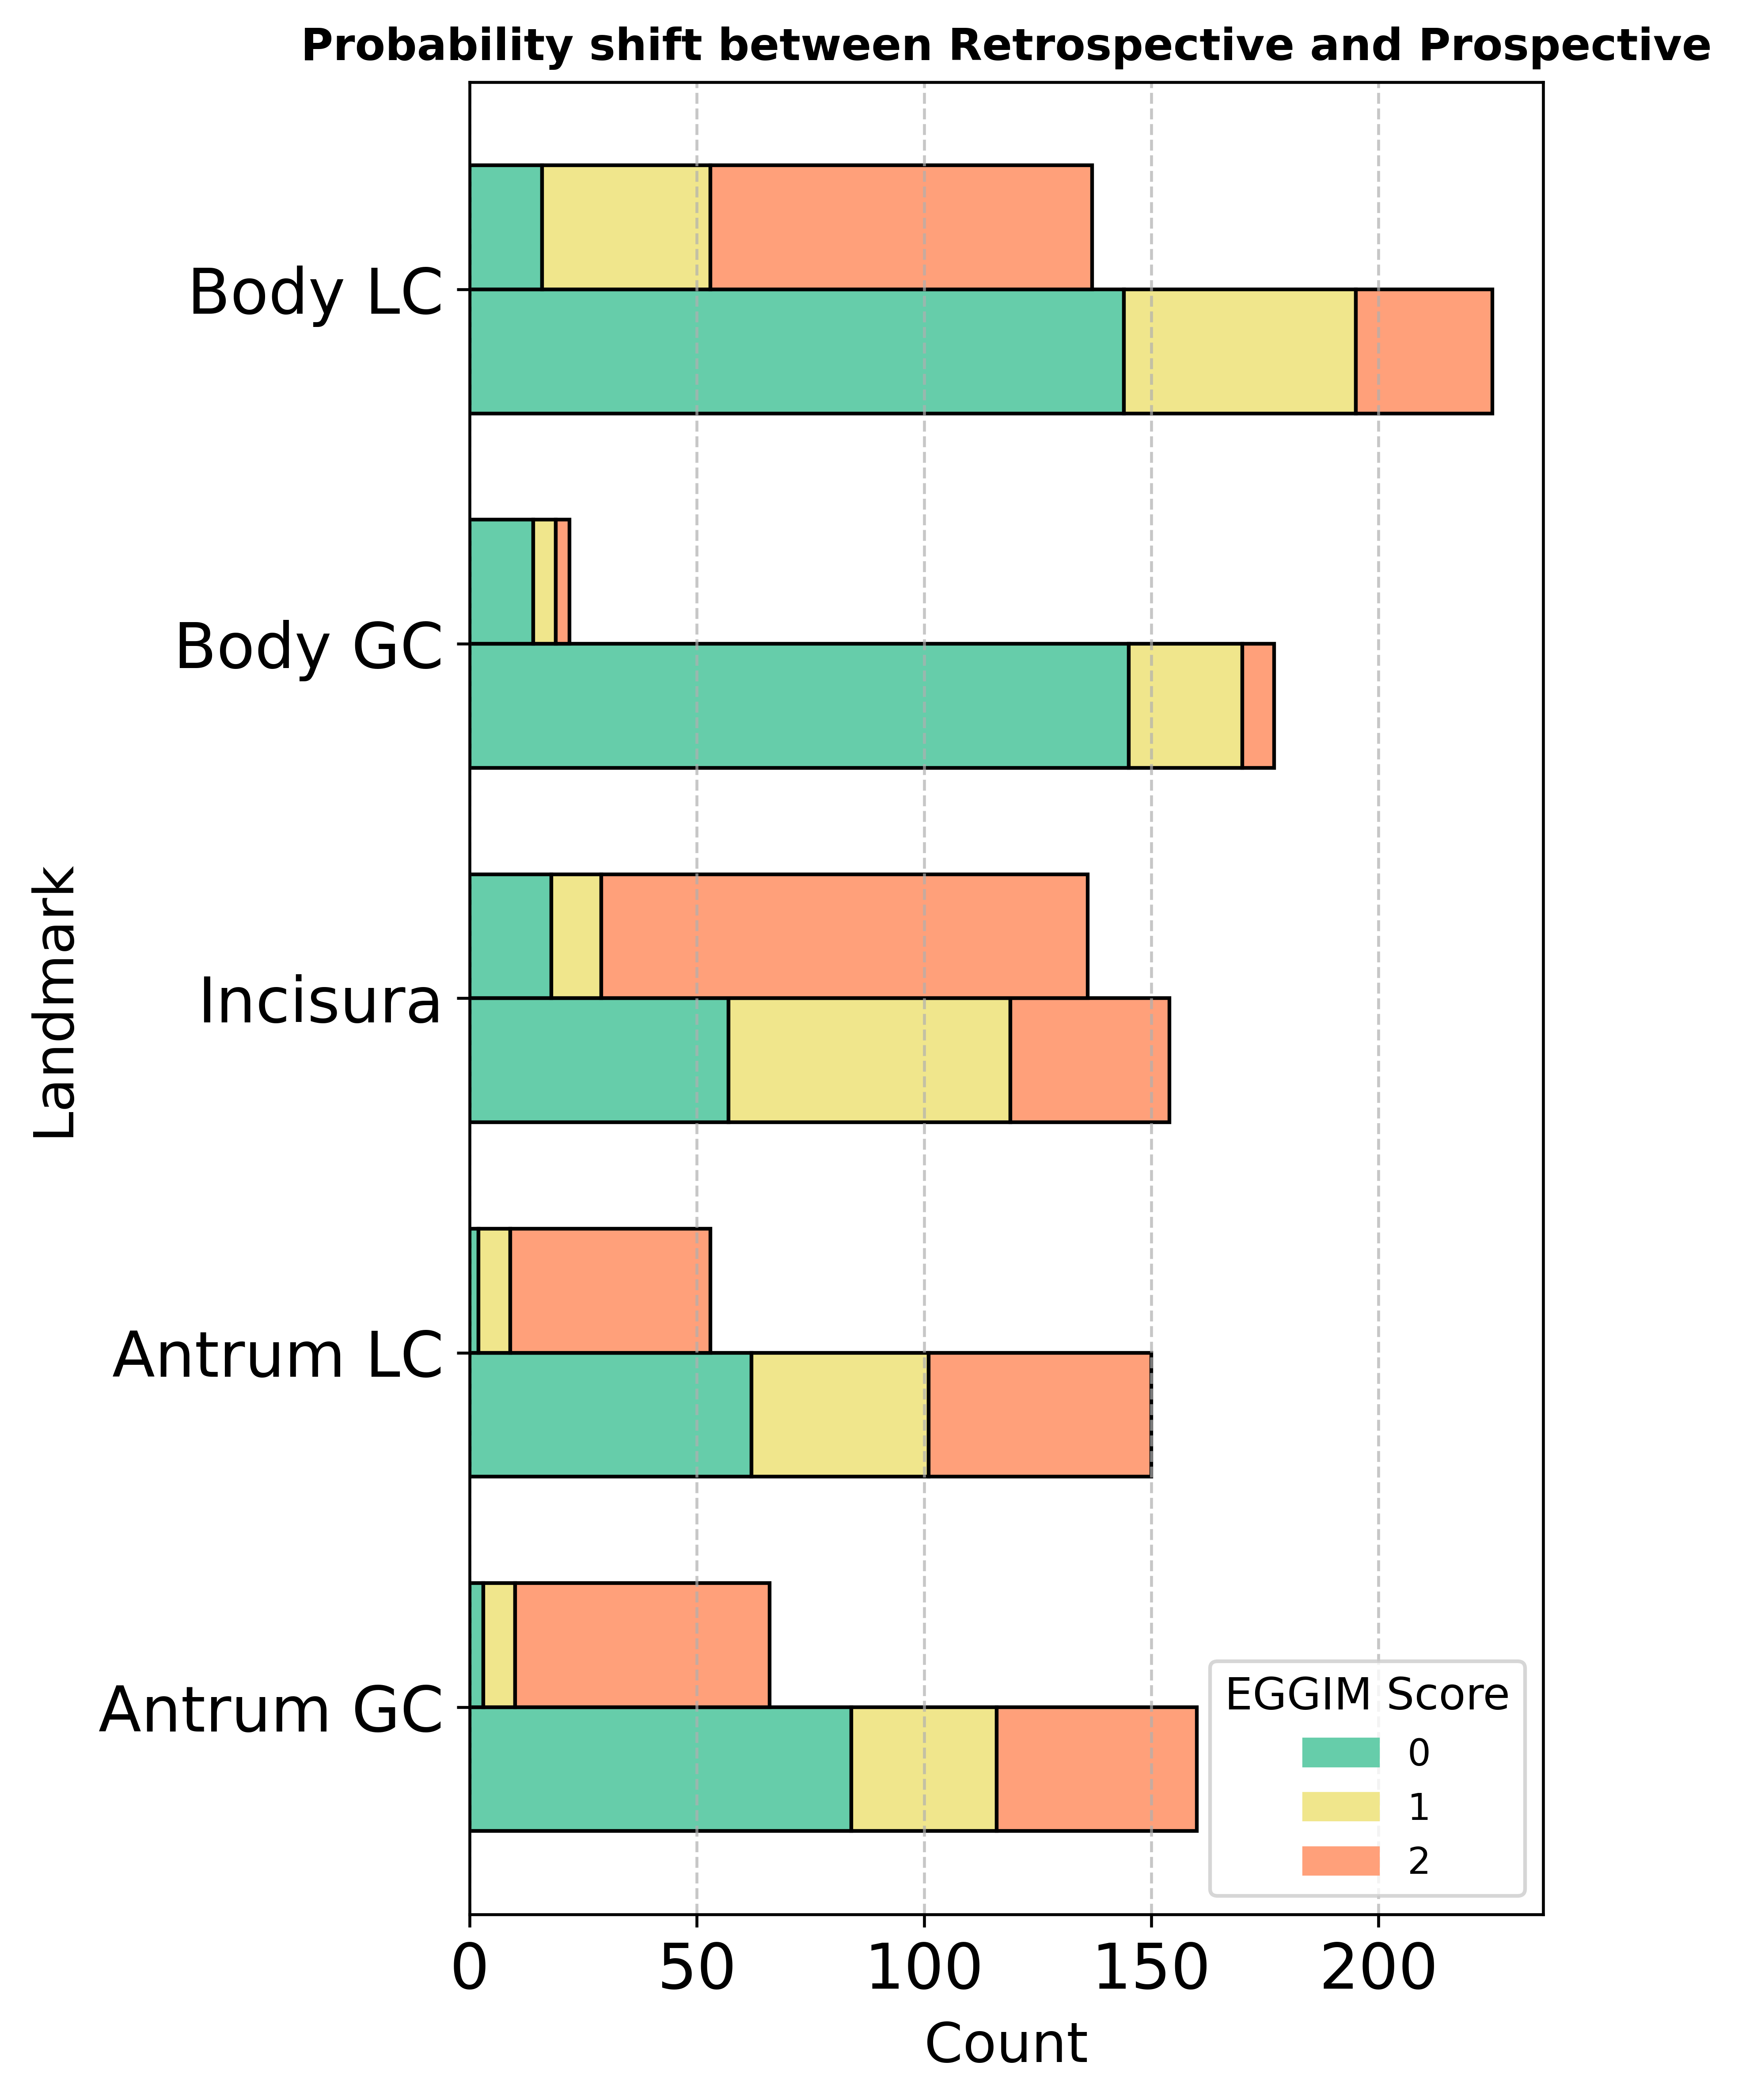

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_pivot_table_grouped_stacked(df1, df2, df1_name='IPO+TOGAS 1', df2_name='IPO+TOGAS 2', dpi=600):
    # Define the custom order for landmarks
    custom_order = ['Antrum GC', 'Antrum LC',  'Incisura', 'Body GC', 'Body LC']

    # Set the custom order for the 'landmark' column in each dataframe
    df1['landmark'] = pd.Categorical(df1['landmark'], categories=custom_order, ordered=True)
    df2['landmark'] = pd.Categorical(df2['landmark'], categories=custom_order, ordered=True)

    # Create pivot tables
    pivot_table1 = pd.crosstab(df1['landmark'], df1['eggim_global'])
    pivot_table2 = pd.crosstab(df2['landmark'], df2['eggim_global'])

    # Find all unique EGGIM score values across both dataframes
    unique_values = sorted(set(df1['eggim_global']).union(set(df2['eggim_global'])))

    # Define colors for each EGGIM score category
    colors = ['mediumaquamarine', 'khaki', 'lightsalmon']  # Adjust or add more colors if needed
    color_mapping = {value: colors[i % len(colors)] for i, value in enumerate(unique_values)}

    # Convert the pivot tables to have a multi-index on columns: (DatasetName, EGGIM_Score)
    pivot_table1.columns = pd.MultiIndex.from_product([[df1_name], pivot_table1.columns])
    pivot_table2.columns = pd.MultiIndex.from_product([[df2_name], pivot_table2.columns])

    # Combine both pivot tables horizontally
    combined = pd.concat([pivot_table1, pivot_table2], axis=1)

    # Ensure the columns are in a consistent order: first by dataset, then by EGGIM score
    combined = combined.reindex(columns=pd.MultiIndex.from_product([[df1_name, df2_name], unique_values]))

    # Reindex rows to match the custom order
    combined = combined.reindex(custom_order)

    fig, ax = plt.subplots(figsize=(6, 8), dpi=dpi)  # Adjust figure size for single-column fit

    # Number of landmarks
    y = np.arange(len(combined.index))
    width = 0.35  # width of each group's bars

    # Plot the first dataset's stacked bars (df1)
    left = np.zeros(len(y))
    for eggim in unique_values:
        x = combined[(df1_name, eggim)].values
        ax.barh(y - width/2, x, width, left=left,
                color=color_mapping[eggim], edgecolor='black', label=f'{df1_name} - {eggim}')
        left += x

    # Plot the second dataset's stacked bars (df2)
    left = np.zeros(len(y))
    for eggim in unique_values:
        x = combined[(df2_name, eggim)].values
        ax.barh(y + width/2, x, width, left=left,
                color=color_mapping[eggim], edgecolor='black', label=f'{df2_name} - {eggim}')
        left += x

    # Set axis labels and title
    ax.set_ylabel('Landmark', fontsize=15, labelpad=5)
    ax.set_xlabel('Count', fontsize=15, labelpad=5)
    ax.set_yticks(y)
    ax.set_yticklabels(combined.index, fontsize=17)
    ax.tick_params(axis='x', labelsize=17)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.set_title(f'Probability shift between {df1_name} and {df2_name}', fontsize=12, fontweight='bold')

    # Add a horizontal legend below the title
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[val], edgecolor='black') for val in unique_values]
    labels = [str(val) for val in unique_values]
    ax.legend(handles, labels, title='EGGIM Score', title_fontsize=12, fontsize=10, ncol=1, loc='best')

    plt.tight_layout(pad=1)
    plt.savefig('prob_shift.png', bbox_inches='tight', dpi=300)
    plt.show()

# Example usage:
plot_pivot_table_grouped_stacked(df_togas, df_ipo, 'Retrospective', 'Prospective', dpi=600)


In [40]:
!pwd

/home/miguelmartins/Projects/eggimazing/notebooks


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

<Figure size 1000x600 with 0 Axes>

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

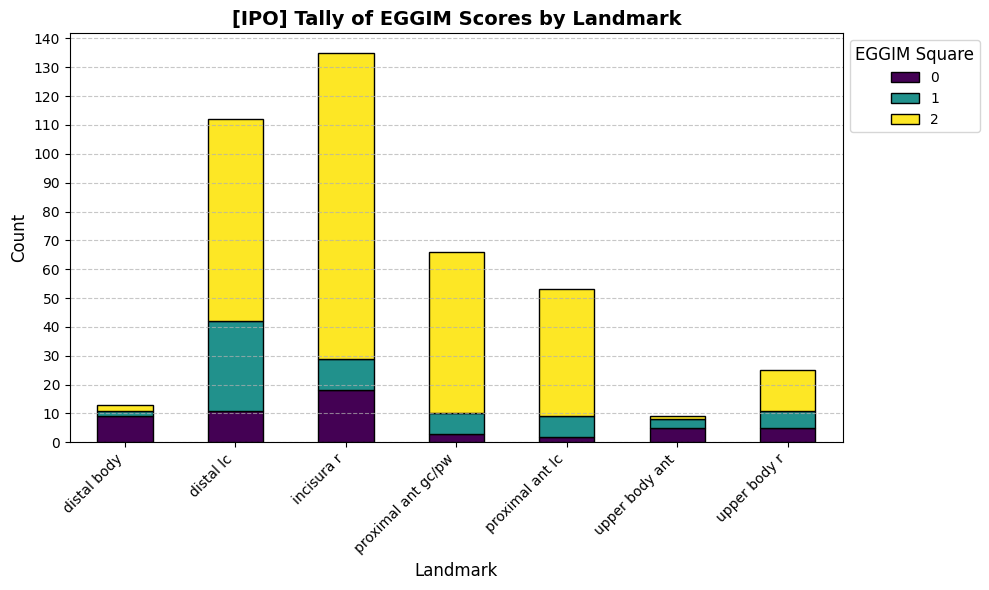

In [45]:
plot_pivot_table(df_ipo, 'IPO')

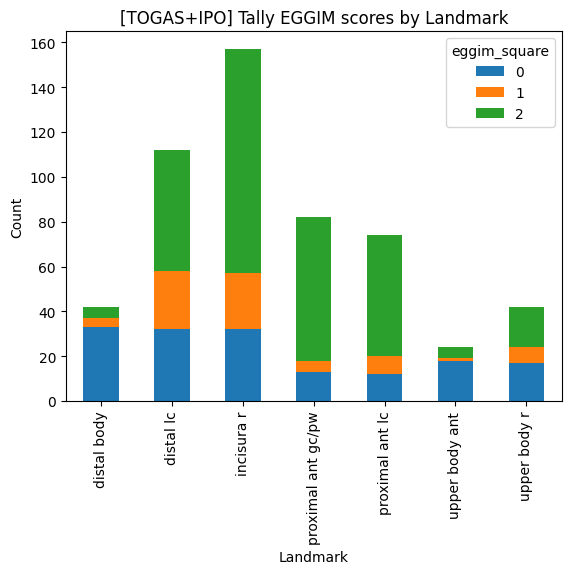

In [18]:
plot_pivot_table(pd.concat([df_togas, df_ipo], axis=0), 'TOGAS+IPO')

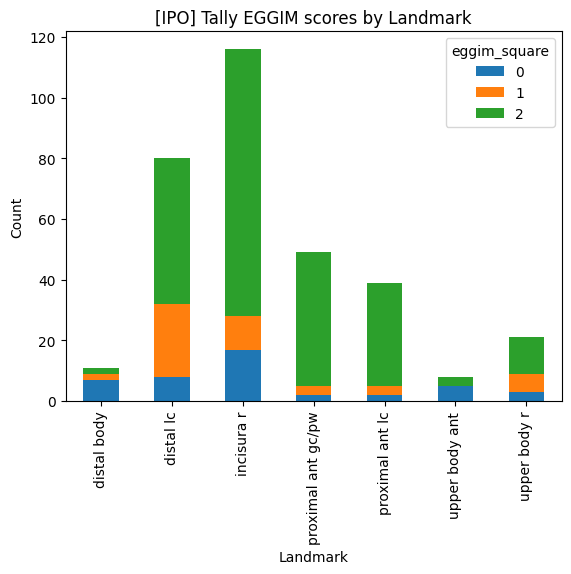

In [19]:
plot_pivot_table(df_ipo, 'IPO')

In [20]:

patient_ids = np.load('../configs/test_patient_ids.npy', allow_pickle=True)
num_folds = 5
dp = DatasetProcessor(target_dir)
df = dp.process()
def replace_landmark_name(landmark):
    new_landmark_name = {'ii': 'distal body',
                    'ix': 'distal lc',
                    'vi': 'proximal ant lc',
                    'vii': 'proximal ant gc/pw',
                    'viii': 'incisura r',
                    'x': 'upper body r',
                    'xii': 'upper body ant'}
    landmark_number = landmark.split('.')[0]
    return new_landmark_name[landmark_number]
df['landmark'] = df['landmark'].apply(replace_landmark_name)
togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)

split_patient_wise = dp.smarter_patient_splits(df_togas,
                               df_ipo,
                               patient_ids,
                               internal_train_size=0.9,
                               target_variable='eggim_square',
                               random_state=42)

togas_only_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_patient_wise]

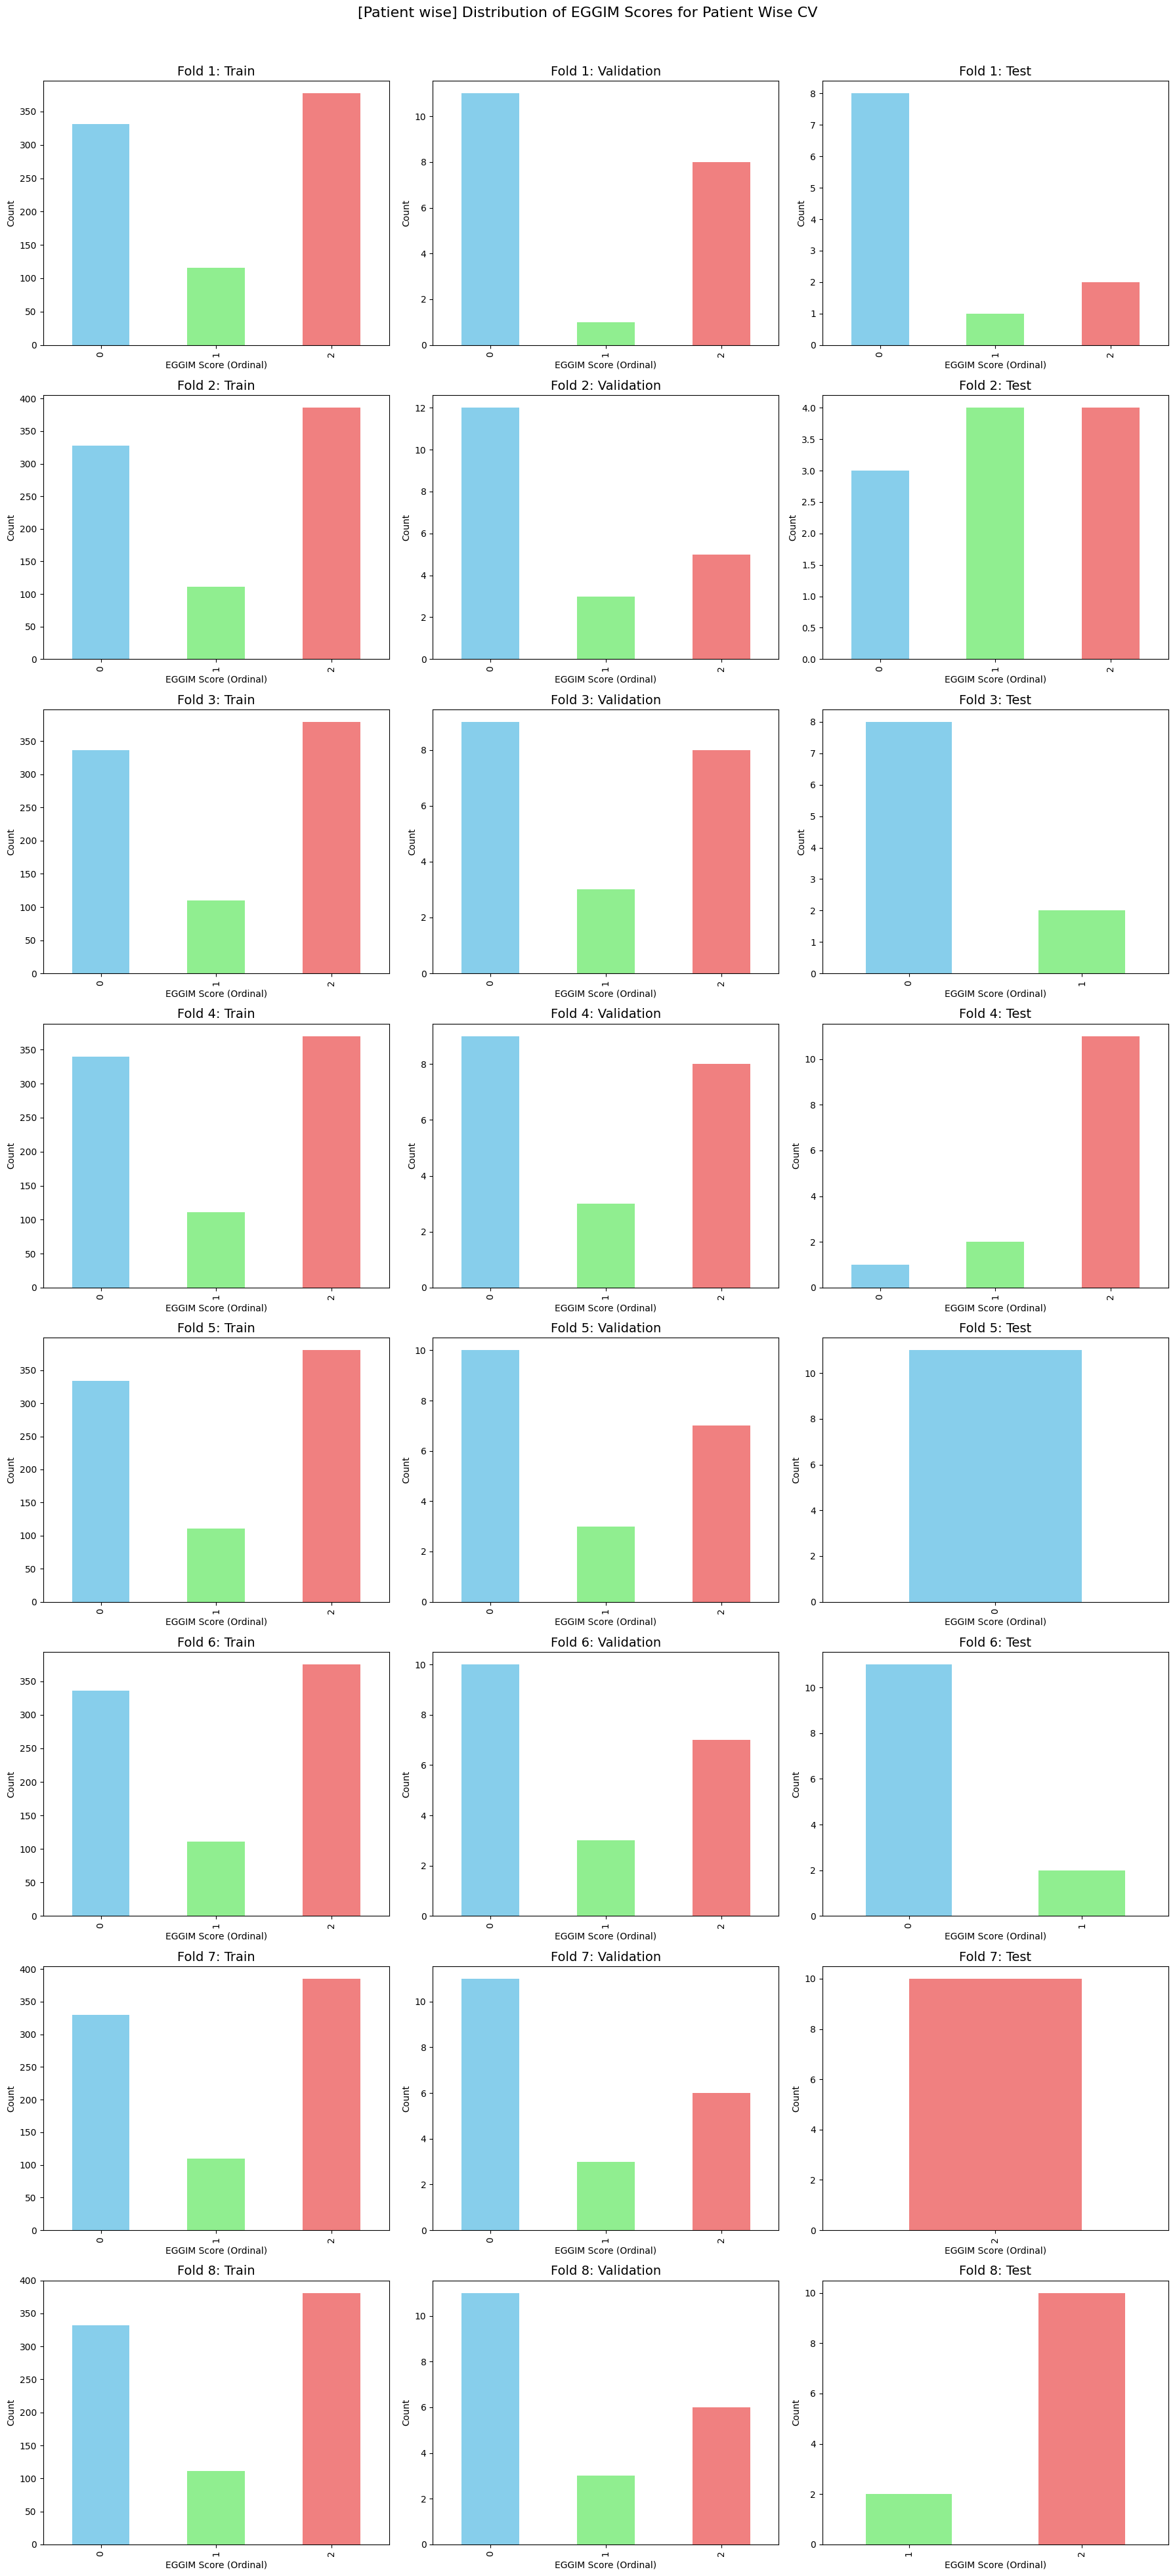

In [21]:
plot_ordinal_distribution_side_by_side_with_colors(togas_only_splits, 'Patient wise')

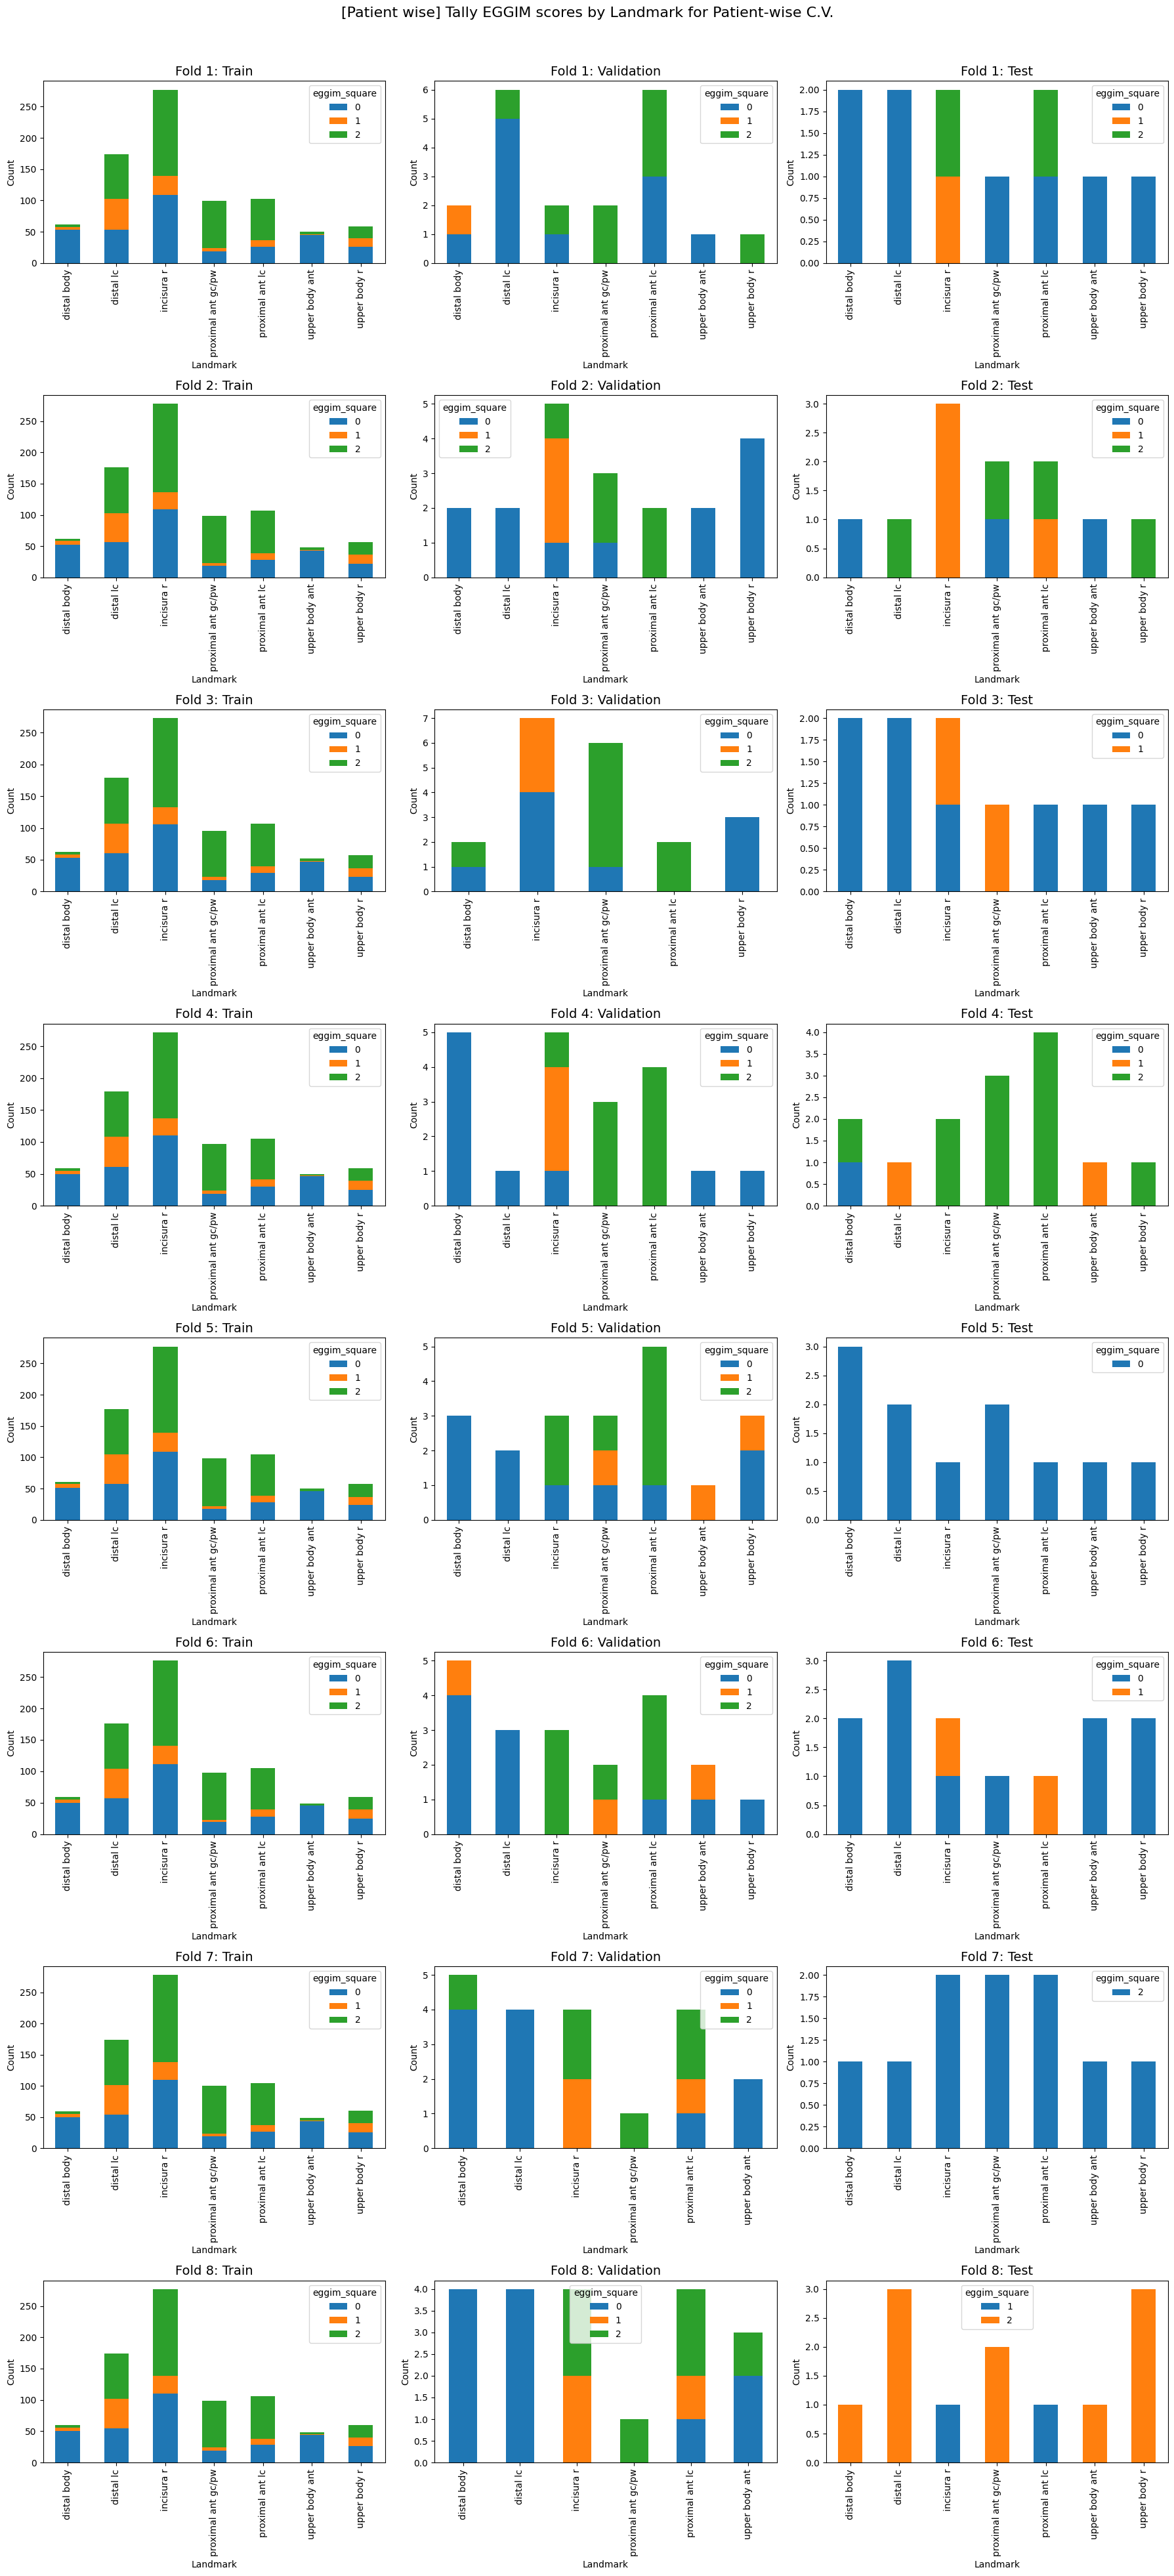

In [22]:
plot_pivot_table_side_by_side(togas_only_splits, 'Patient wise')